# **Citrus Leaf Disease Image Classification**

###**Introduction**
 * By using Convolutional Neural Networks (CNNs), a powerful subset of deep learning models tailored for image recognition tasks, this implementation aims to accurately identify four distinct categories of citrus leaf diseases: Black spot, Canker, Greening, and Healthy.

In [ ]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Pre-processing

**1. Data Loading**
* Dataset link - https://www.kaggle.com/datasets/myprojectdictionary/citrus-leaf-disease-image

In [ ]:
base_dir = '/content/drive/My Drive/zap/Citrus Leaf Disease Image'

**2. Data Augmentation**
* Data augmentation is a technique used to artificially increase the diversity of a dataset by applying transformations such as rotation, scaling, flipping, and cropping to existing data samples.
* It is needed in CNN training to improve model generalization, prevent overfitting, and enhance robustness by exposing the model to a wider range of variations and scenarios present in real-world data.

* An ImageDataGenerator instance is created with parameters specifying rotation, shifting, shearing, zooming, flipping, and fill mode for augmentation.
* It loops through each subfolder, loads images, and applies augmentation using the generator.
* Augmented images are saved with prefixed filenames. This process is repeated for each image in each subfolder, generating five augmented images for each original image.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='png'):
                i += 1
                if i >= 5:
                    break


Printing number of images in each folder

In [ ]:
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([filename for filename in os.listdir(folder_path) if filename.endswith('.png') ])
        print(f"Folder '{folder}' contains {num_images} images.")

Folder 'Canker' contains 943 images.
Folder 'Black spot' contains 980 images.
Folder 'Healthy' contains 344 images.
Folder 'Greening' contains 1168 images.


**3.Image-Resizing**

* Loop through each subdirectory in the base directory
* Check if the item is a directory
* Loop through each image file in the subdirectory
* Check if the file is an image
*  Open the image file
*  Resize the image
* Save the resized image (overwrite the original)

In [ ]:
target_width = 224
target_height = 224

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path)
                resized_img = img.resize((target_width, target_height))
                resized_img.save(img_path)
                # print(f"Resized {filename} in '{folder}' to {target_width}x{target_height} pixels.")

# 2.Model Implementation

**Test-Train Splitting**

* Directory Creation: It creates two directories within the specified base_dir - one for training data (train_dir) and another for validation data (validation_dir). If these directories already exist, it does not raise an error (exist_ok=True).
* Class-wise Data Splitting: It iterates over each class directory within the base_dir. For each class, it lists all the images (class_images) in that class directory.
* Shuffling: It shuffles the list of image filenames within each class directory to introduce randomness in the data.
* Validation Data Selection: It calculates the number of images to be moved to the validation directory based on the validation_split ratio. It then moves the specified percentage of images from each class to the validation directory while maintaining the class-wise directory structure.
* Training Data Selection: The remaining images (after selecting the validation set) are moved to the training directory.
* Directory Structure Preservation: During the move operation, it creates the necessary subdirectories within the train_dir and validation_dir to maintain the original class-wise directory structure.
* Output: Finally, it returns the paths of the training and validation directories (train_dir and validation_dir) to the caller.

**shutil module**
* The shutil module in Python provides a higher-level interface for file operations, including copying and moving files or entire directory trees.
* In the code the shutil.move() function is used to move image files from one directory to another.

In [ ]:
# def custom_data_preprocessing(base_dir, validation_split=0.2):
#     train_dir = os.path.join(base_dir, 'Train')
#     validation_dir = os.path.join(base_dir, 'Validation')
#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(validation_dir, exist_ok=True)

#     for class_name in os.listdir(base_dir):
#         class_images = os.listdir(os.path.join(base_dir, class_name))
#         random.shuffle(class_images)
#         num_validation = int(len(class_images) * validation_split)

#         for image_name in class_images[:num_validation]:
#             src = os.path.join(base_dir, class_name, image_name)
#             dest = os.path.join(validation_dir, class_name, image_name)
#             if not os.path.exists(dest):  # Check if destination does not exist
#                 os.makedirs(os.path.dirname(dest), exist_ok=True)
#                 shutil.move(src, dest)+

#         for image_name in class_images[num_validation:]:
#             src = os.path.join(base_dir, class_name, image_name)
#             dest = os.path.join(train_dir, class_name, image_name)
#             if not os.path.exists(dest):  # Check if destination does not exist
#                 os.makedirs(os.path.dirname(dest), exist_ok=True)
#                 shutil.move(src, dest)

#     return train_dir, validation_dir

In [ ]:
# train_dir, validation_dir = custom_data_preprocessing(base_dir)

In [ ]:
train_dir = '/content/drive/My Drive/zap/Train'

In [ ]:
validation_dir = '/content/drive/My Drive/zap/Validation'

Printing the sub-directories and number of images inside each subdirectory in the Train folder

In [ ]:
base_dir = '/content/drive/My Drive/zap/Train'
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([filename for filename in os.listdir(folder_path) if filename.endswith('.png') ])
        print(f"Folder '{folder}' contains {num_images} images.")

Folder 'Canker' contains 755 images.
Folder 'Black spot' contains 784 images.
Folder 'Healthy' contains 276 images.
Folder 'Greening' contains 935 images.


Printing the sub-directories and number of images inside each subdirectory in the Validation folder

In [ ]:
base_dir = '/content/drive/My Drive/zap/Validation'
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([filename for filename in os.listdir(folder_path) if filename.endswith('.png') ])
        print(f"Folder '{folder}' contains {num_images} images.")

Folder 'Canker' contains 188 images.
Folder 'Black spot' contains 196 images.
Folder 'Healthy' contains 68 images.
Folder 'Greening' contains 233 images.


* img_width and img_height determine the input image size, typically set to 224x224 pixels.
*  num_classes represents the number of distinct categories the model will predict
*  batch_size controls the number of samples processed in each training iteration
* epochs defines the number of complete passes through the dataset during training.

In [ ]:
img_width = 224
img_height = 224
num_classes = 4
batch_size = 32
epochs = 5

**Label-encoding**

* The load_images_from_directory function loads images directly from the directories specified by train_dir and validation_dir.
* It loops through each subdirectory (which corresponds to a class) within the main directory, loads the images, and converts them into NumPy arrays.
* Labels are assigned based on the subdirectory names.
* The LabelEncoder is used to encode the class labels into categorical format.
* The images and labels are loaded separately for both training and validation datasets

In [ ]:
def load_images_from_directory(directory, img_width, img_height):
    images = []
    labels = []
    label_encoder = LabelEncoder()

    for label_name in os.listdir(directory):
        label = label_name
        label_dir = os.path.join(directory, label_name)
        for img_filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_filename)
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

    # Convert labels to categorical format
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)

    return np.array(images), labels

Loads images from the directories and converts them into NumPy arrays, along with their corresponding labels.

In [ ]:
X_train, y_train = load_images_from_directory(train_dir, img_width, img_height)
X_val, y_val = load_images_from_directory(validation_dir, img_width, img_height)

The pixel values of the images are normalized to the range [0, 1].

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0

# Model-1

* Two convolutional layers with ReLU activation functions followed by max-pooling layers.
* A Flatten layer to convert the 2D output of the convolutional layers into a 1D vector.
* A fully connected Dense layer with 512 units and ReLU activation.
* A Dropout layer with a dropout rate of 0.25 to reduce overfitting.
* Finally, a Dense output layer with softmax activation for multiclass classification.

In [ ]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])


* Compiles the defined model using the
 * optimizer (Adam),
 * the loss function (categorical cross-entropy),
 * and the evaluation metric (accuracy)

In [ ]:
model_1.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


* Compiled model is trained on the training data (X_train, y_train) for the specified number of epochs (epochs) and batch size (batch_size).
* The validation data (X_val, y_val) is used for validation during training.

In [ ]:
history = model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/5
86/86 [==============================] - 17s 106ms/step - loss: 2.3403 - accuracy: 0.4658 - val_loss: 1.0519 - val_accuracy: 0.4876
Epoch 2/5
86/86 [==============================] - 6s 73ms/step - loss: 0.8244 - accuracy: 0.6255 - val_loss: 0.9886 - val_accuracy: 0.5869
Epoch 3/5
86/86 [==============================] - 7s 83ms/step - loss: 0.6157 - accuracy: 0.7444 - val_loss: 1.0567 - val_accuracy: 0.5445
Epoch 4/5
86/86 [==============================] - 7s 83ms/step - loss: 0.7017 - accuracy: 0.7109 - val_loss: 0.6807 - val_accuracy: 0.7314
Epoch 5/5
86/86 [==============================] - 6s 73ms/step - loss: 0.4125 - accuracy: 0.8462 - val_loss: 0.7070 - val_accuracy: 0.7124


Plots the training and validation accuracies over epochs

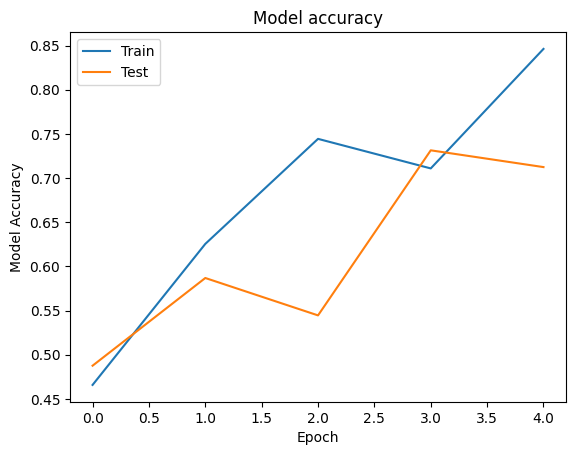

In [ ]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Test')
plt.title('Model accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Accuracy and loss on Test-data

In [ ]:
loss, accuracy = model_1.evaluate(X_val, y_val)
print("Accuracy on test data:", accuracy)

22/22 [==============================] - 1s 22ms/step - loss: 0.7070 - accuracy: 0.7124
Accuracy on test data: 0.7124087810516357


Saving the trained model

In [ ]:
model_1.save('/content/drive/My Drive/zap/Model_1.h5')

# Model-2

* Four Conv2D layers with ReLU activation functions followed by MaxPooling2D layers for feature extraction.
* A Flatten layer to flatten the 2D feature maps into a 1D vector.
* A Dropout layer with a dropout rate of 0.25 to reduce overfitting.
* Two Dense layers with ReLU activation, where the last layer has a softmax activation for classification.

In [ ]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])


In [ ]:
model_2.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model_2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/5
86/86 [==============================] - 10s 65ms/step - loss: 1.0923 - accuracy: 0.4600 - val_loss: 0.6807 - val_accuracy: 0.6847
Epoch 2/5
86/86 [==============================] - 4s 52ms/step - loss: 0.6052 - accuracy: 0.7378 - val_loss: 0.7019 - val_accuracy: 0.6876
Epoch 3/5
86/86 [==============================] - 4s 51ms/step - loss: 0.4058 - accuracy: 0.8513 - val_loss: 0.3027 - val_accuracy: 0.9066
Epoch 4/5
86/86 [==============================] - 4s 48ms/step - loss: 0.3104 - accuracy: 0.8960 - val_loss: 0.3637 - val_accuracy: 0.8818
Epoch 5/5
86/86 [==============================] - 4s 50ms/step - loss: 0.2568 - accuracy: 0.9105 - val_loss: 0.2278 - val_accuracy: 0.9299


Plots the training and validation accuracies over epochs

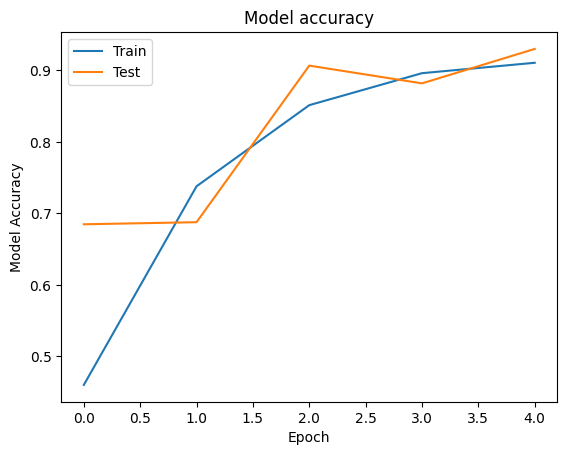

In [ ]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Test')
plt.title('Model accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Accuracy and loss on Test-data

In [ ]:
loss, accuracy = model_2.evaluate(X_val, y_val)
print("Accuracy on test data:", accuracy)

22/22 [==============================] - 1s 25ms/step - loss: 0.2278 - accuracy: 0.9299
Accuracy on test data: 0.9299269914627075


Saving the model

In [ ]:
model_2.save('/content/drive/My Drive/zap/Model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model-3

* Six Conv2D layers with ReLU activation functions followed by MaxPooling2D layers for feature extraction.
* A Flatten layer to flatten the 2D feature maps into a 1D vector.
*  A Dropout layer with a dropout rate of 0.25 to reduce overfitting.
* Two Dense layers with ReLU activation, where the last layer has a softmax activation for classification.

In [ ]:
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])


In [ ]:
model_3.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model_3.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/5
86/86 [==============================] - 11s 65ms/step - loss: 1.1774 - accuracy: 0.4124 - val_loss: 1.0766 - val_accuracy: 0.4701
Epoch 2/5
86/86 [==============================] - 4s 51ms/step - loss: 1.0441 - accuracy: 0.4935 - val_loss: 0.9318 - val_accuracy: 0.5693
Epoch 3/5
86/86 [==============================] - 5s 54ms/step - loss: 0.8829 - accuracy: 0.5785 - val_loss: 1.4703 - val_accuracy: 0.3635
Epoch 4/5
86/86 [==============================] - 4s 51ms/step - loss: 0.8349 - accuracy: 0.5724 - val_loss: 0.6807 - val_accuracy: 0.6599
Epoch 5/5
86/86 [==============================] - 4s 49ms/step - loss: 0.6822 - accuracy: 0.6593 - val_loss: 0.7253 - val_accuracy: 0.6949


Plots the training and validation accuracies over epochs

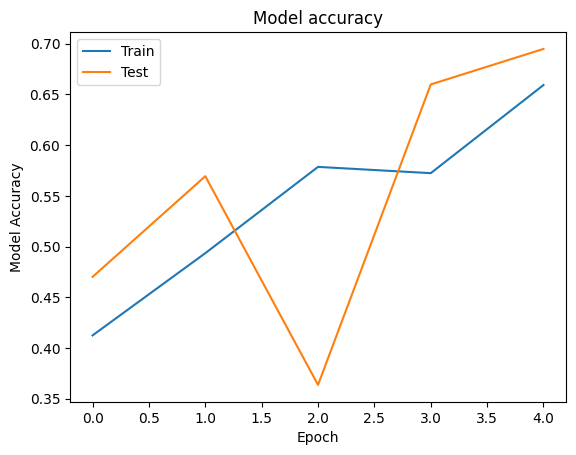

In [ ]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Test')
plt.title('Model accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Accuracy and loss on Test-data

In [ ]:
loss, accuracy = model_3.evaluate(X_val, y_val)
print("Accuracy on test data:", accuracy)

22/22 [==============================] - 0s 21ms/step - loss: 0.7253 - accuracy: 0.6949
Accuracy on test data: 0.6948904991149902


Saving the model

In [ ]:
model_3.save('/content/drive/My Drive/zap/Model_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 3. Selection of Model

**Model-1:**
* Loss: 0.7070
* Accuracy: 0.7124

**Summary:**
* Model-1 achieves a moderate accuracy of approximately 71.24% on the test data. However, it exhibits a relatively high loss value, indicating suboptimal performance compared to other models.

**Model-2:**
* Loss: 0.2278
* Accuracy: 0.9299

**Summary:**
* Model-2 demonstrates superior performance with a significantly lower loss of 0.2278 and a substantially higher accuracy of approximately 92.99% on the test data.

**Model-3:**
* Loss: 0.7253
* Accuracy: 0.6949

**Summary:**
* Model-3 exhibits the lowest accuracy of approximately 69.49% on the test data, along with a relatively high loss value of 0.7253.It's performance in terms of accuracy and loss is inferior compared to both Model-1 and Model-2.

**Conclusion:**
Model-2 outperforms both Model-1 and Model-3 in terms of accuracy and loss metrics, demonstrating a significant improvement in predictive performance. Therefore, Model-2 is the best among three.

# 4.Testing

In [ ]:
import numpy as np
from PIL import Image

def predict_image_class(image_path, model, class_names):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

In [ ]:
class_names = ['Black spot', 'Canker', 'Greening', 'Healthy']
predicted_class = predict_image_class('/content/drive/My Drive/zap/Validation/Canker/Image (154).png', model_2, class_names)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 44ms/step
Predicted Class: Canker
